In [38]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import StandardScaler


# CARGA Y PREPROCESAMIENTO DE DATOS CON DATASET LUXEMBURGO


In [41]:

df = pd.read_csv("Temp-Luxemburgo.csv")

print(f"Dataset Luxemburgo cargado: {len(df)} registros")
print(f"Columnas disponibles: {list(df.columns)}")

print(f"\nEstructura del dataset:")
print(f"- Fechas: {df['fecha'].min()} a {df['fecha'].max()}")
print(f"- Temperatura: {df['temperatura'].min():.1f}°C a {df['temperatura'].max():.1f}°C")

variables_adicionales = ['presion', 'punto_rocio']
print(f"Variables adicionales: {variables_adicionales}")

y = df['temperatura'].values
ventana = 30

print(f"\nEstadísticas temperatura:")
print(f"- Media: {y.mean():.2f}°C")
print(f"- Desviación estándar: {y.std():.2f}°C")
print(f"- Rango: {y.min():.1f}°C a {y.max():.1f}°C")
print(f"Ventana temporal: {ventana} días")

Dataset Luxemburgo cargado: 20000 registros
Columnas disponibles: ['fecha', 'temperatura', 'mes', 'dia_del_ano', 'dia_seno', 'dia_coseno', 'mes_seno', 'mes_coseno', 'presion', 'punto_rocio']

Estructura del dataset:
- Fechas: 1970-03-31 a 2024-12-31
- Temperatura: -18.0°C a 42.0°C
Variables adicionales: ['presion', 'punto_rocio']

Estadísticas temperatura:
- Media: 12.11°C
- Desviación estándar: 11.89°C
- Rango: -18.0°C a 42.0°C
Ventana temporal: 30 días


In [42]:
# CONSTRUCCIÓN DE FEATURES

def construir_matriz_lags(y_array, ventana):
    """Crear matriz de valores pasados (lags)"""
    X_lags = []
    for t in range(ventana, len(y_array)):
        X_lags.append(y_array[t-ventana:t][::-1])
    return np.array(X_lags)

ventana = 30
X_lags = construir_matriz_lags(y, ventana)

# Features temporales cíclicas
nombres_temporales = ['dia_seno', 'dia_coseno', 'mes_seno', 'mes_coseno']
caracteristicas_temporales = []
for t in range(ventana, len(df)):
    temp_feats = [df[feat].iloc[t] for feat in nombres_temporales]
    caracteristicas_temporales.append(temp_feats)
X_temporal = np.array(caracteristicas_temporales)

# Variables adicionales
variables_adicionales = ['presion', 'punto_rocio']
X_adicional = []
for t in range(ventana, len(df)):
    add_feats = [df[col].iloc[t] for col in variables_adicionales]
    X_adicional.append(add_feats)
X_adicional = np.array(X_adicional)

# Combinar todas las características
X = np.hstack([X_lags, X_temporal, X_adicional])
y_objetivo = y[ventana:]

# División de datos
N = len(y_objetivo)
split_punto = int(N * 0.8)

X_entrenamiento, X_validacion = X[:split_punto], X[split_punto:]
y_entrenamiento, y_validacion = y_objetivo[:split_punto], y_objetivo[split_punto:]

# Normalización
escalador_X = StandardScaler()
X_entrenamiento_norm = escalador_X.fit_transform(X_entrenamiento)
X_validacion_norm = escalador_X.transform(X_validacion)

escalador_y = StandardScaler()
y_entrenamiento_norm = escalador_y.fit_transform(y_entrenamiento.reshape(-1, 1)).reshape(-1)
y_validacion_norm = escalador_y.transform(y_validacion.reshape(-1, 1)).reshape(-1)

print(f"Datos preparados:")
print(f"- Entrenamiento: {len(X_entrenamiento):,} muestras")
print(f"- Validación: {len(X_validacion):,} muestras")
print(f"- Features por muestra: {X_entrenamiento.shape[1]}")

Datos preparados:
- Entrenamiento: 15,976 muestras
- Validación: 3,994 muestras
- Features por muestra: 36


In [43]:
# DATASET Y DATALOADER

class DatasetTemperatura(Dataset):
    """Dataset personalizado para predicción de temperatura"""
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).float().view(-1, 1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]

dataset = {
    'entrenamiento': DatasetTemperatura(X_entrenamiento_norm, y_entrenamiento_norm),
    'validacion': DatasetTemperatura(X_validacion_norm, y_validacion_norm)
}

dataloader = {
    'entrenamiento': DataLoader(dataset['entrenamiento'], batch_size=32, shuffle=True),
    'validacion': DataLoader(dataset['validacion'], batch_size=1000, shuffle=False)
}

def construir_modelo(dim_entrada, neuronas_ocultas=64, dim_salida=1):
    return nn.Sequential(
        nn.Linear(dim_entrada, neuronas_ocultas),
        nn.ReLU(),
        nn.Linear(neuronas_ocultas, neuronas_ocultas),
        nn.ReLU(),
        nn.Linear(neuronas_ocultas, dim_salida)
    )

def evaluar_modelo(modelo, dataloader_val, escalador_y, y_real):
    modelo.eval()
    predicciones_norm = []
    
    with torch.no_grad():
        for x_b, _ in dataloader_val:
            y_pred = modelo(x_b)
            predicciones_norm.append(y_pred.numpy().reshape(-1))
    
    predicciones_norm = np.concatenate(predicciones_norm)
    predicciones_reales = escalador_y.inverse_transform(predicciones_norm.reshape(-1, 1)).reshape(-1)
    
    mae = np.mean(np.abs(y_real - predicciones_reales))
    mse = np.mean((y_real - predicciones_reales)**2)
    precision = (1 - mae / np.abs(y_real.mean())) * 100
    
    return {
        'mae': mae, 
        'mse': mse, 
        'precision': precision, 
        'predicciones': predicciones_reales
    }

print(f"Configuración completa para dataset Luxemburgo:")
print(f"Arquitectura del modelo: {X_entrenamiento.shape[1]} → 64 → 64 → 1 ")
print(f"Datasets y DataLoaders preparados")
print(f"Función de evaluación lista")

Configuración completa para dataset Luxemburgo:
Arquitectura del modelo: 36 → 64 → 64 → 1 
Datasets y DataLoaders preparados
Función de evaluación lista


# FUNCIÓN DE ENTRENAMIENTO OPTIMIZADA PARA LUXEMBURGO


In [44]:

def entrenar_modelo(modelo, optimizador, dataloader, epocas=100, paciencia=10, nombre=""):

    criterio = nn.MSELoss()
    perdidas_entrenamiento, perdidas_validacion = [], []
    mejor_perdida_val = float('inf')
    contador_paciencia = 0
    
    print(f"Iniciando entrenamiento de {nombre}...")
    
    for epoca in range(1, epocas + 1):
        modelo.train()
        perdidas_lote = []
        
        for x_b, y_b in dataloader['entrenamiento']:
            y_pred = modelo(x_b)
            perdida = criterio(y_pred, y_b)
            
            optimizador.zero_grad()
            perdida.backward()
            optimizador.step()
            
            perdidas_lote.append(perdida.item())
        
        perdidas_entrenamiento.append(np.mean(perdidas_lote))
        
        modelo.eval()
        perdidas_val_lote = []
        
        with torch.no_grad():
            for x_b, y_b in dataloader['validacion']:
                y_pred = modelo(x_b)
                perdida = criterio(y_pred, y_b)
                perdidas_val_lote.append(perdida.item())
        
        perdidas_validacion.append(np.mean(perdidas_val_lote))
        
        if perdidas_validacion[-1] < mejor_perdida_val:
            mejor_perdida_val = perdidas_validacion[-1]
            contador_paciencia = 0
        else:
            contador_paciencia += 1
            
        if contador_paciencia >= paciencia:
            print(f"{nombre} - Early stopping en época {epoca}")
            break
        
        if epoca % 20 == 0:
            print(f"{nombre} - Época {epoca:3d} | "
                  f"Pérdida entrenamiento: {perdidas_entrenamiento[-1]:.6f} | "
                  f"Pérdida validación: {perdidas_validacion[-1]:.6f}")
    
    return {
        'perdida_entrenamiento': perdidas_entrenamiento,
        'perdida_validacion': perdidas_validacion,
        'epocas_totales': len(perdidas_entrenamiento)
    }

print("Función de entrenamiento optimizada lista")

Función de entrenamiento optimizada lista


# ENTRENAMIENTO CON SGD - DATASET LUXEMBURGO


In [ ]:
print("ENTRENAMIENTO CON OPTIMIZADOR SGD")
print()

modelo_sgd = construir_modelo(X_entrenamiento.shape[1])
optimizador_sgd = torch.optim.SGD(modelo_sgd.parameters(), lr=0.001, momentum=0.9)

historial_sgd = entrenar_modelo(
    modelo_sgd, 
    optimizador_sgd, 
    dataloader, 
    epocas=100, 
    nombre="SGD"
)

resultado_sgd = evaluar_modelo(modelo_sgd, dataloader['validacion'], escalador_y, y_validacion)

mejor_modelo = modelo_sgd
mejor_resultado = resultado_sgd

print(f"\nRESULTADOS SGD - DATASET LUXEMBURGO:")
print(f"   MAE: {resultado_sgd['mae']:.4f}°C")
print(f"   Precisión: {resultado_sgd['precision']:.1f}%")
print(f"   MSE: {resultado_sgd['mse']:.4f}")
print(f"   Épocas entrenadas: {historial_sgd['epocas_totales']}")

print(f"\nModelo SGD entrenado exitosamente con dataset Luxemburgo")

ENTRENAMIENTO CON OPTIMIZADOR SGD
Iniciando entrenamiento de SGD...
SGD - Época  20 | Pérdida entrenamiento: 0.048223 | Pérdida validación: 0.016058
SGD - Época  20 | Pérdida entrenamiento: 0.048223 | Pérdida validación: 0.016058
SGD - Early stopping en época 33

RESULTADOS SGD - DATASET LUXEMBURGO:
   MAE: 1.2964°C
   Precisión: 90.8%
   MSE: 2.6684
   Épocas entrenadas: 33

Modelo SGD entrenado exitosamente con dataset Luxemburgo
SGD - Early stopping en época 33

RESULTADOS SGD - DATASET LUXEMBURGO:
   MAE: 1.2964°C
   Precisión: 90.8%
   MSE: 2.6684
   Épocas entrenadas: 33

Modelo SGD entrenado exitosamente con dataset Luxemburgo


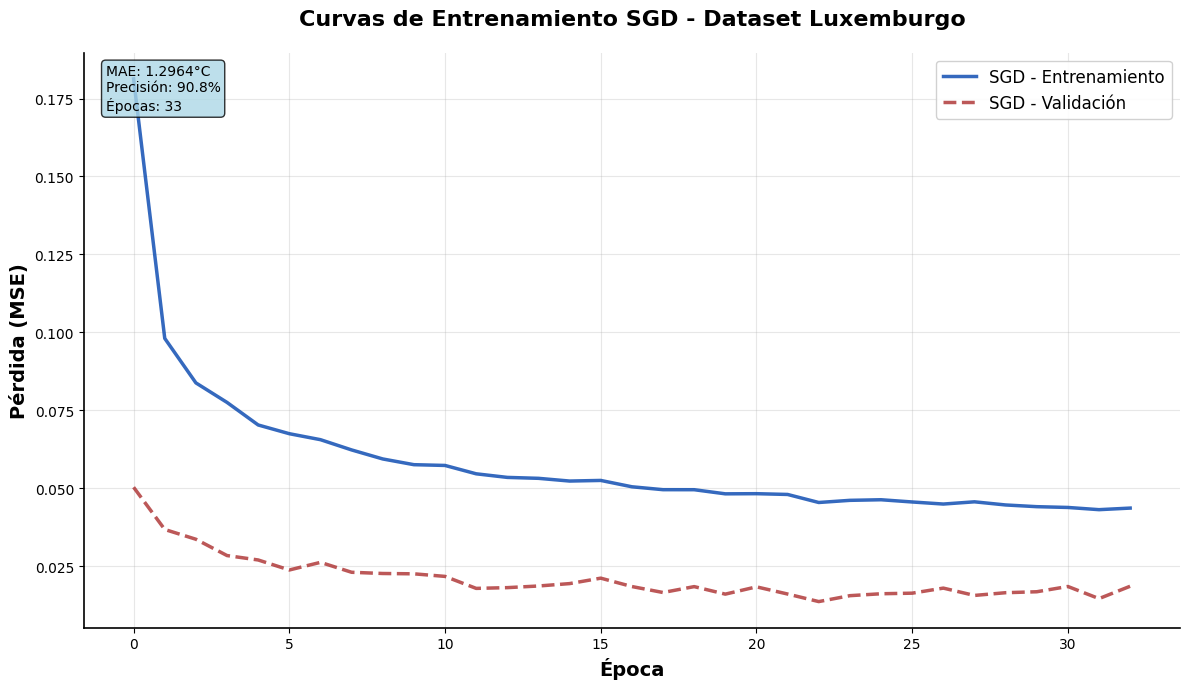

Gráfica de entrenamiento SGD generada
Mejor pérdida de validación: 0.013666


In [23]:
# VISUALIZACIÓN CURVAS DE ENTRENAMIENTO - SGD LUXEMBURGO

fig, ax = plt.subplots(1, 1, figsize=(12, 7))

ax.plot(historial_sgd['perdida_entrenamiento'], 
        label='SGD - Entrenamiento', 
        color="#0244AE", linewidth=2.5, alpha=0.8)
ax.plot(historial_sgd['perdida_validacion'], 
        label='SGD - Validación', 
        color="#AB2E2E", linestyle='--', linewidth=2.5, alpha=0.8)

ax.set_title('Curvas de Entrenamiento SGD - Dataset Luxemburgo', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Época', fontsize=14, fontweight='bold')
ax.set_ylabel('Pérdida (MSE)', fontsize=14, fontweight='bold')
ax.legend(fontsize=12, framealpha=0.9, loc='upper right')
ax.grid(True, alpha=0.3, linewidth=0.8)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

info_text = (f'MAE: {resultado_sgd["mae"]:.4f}°C\n'
             f'Precisión: {resultado_sgd["precision"]:.1f}%\n'
             f'Épocas: {historial_sgd["epocas_totales"]}')

ax.text(0.02, 0.98, info_text, 
        transform=ax.transAxes, 
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
        fontsize=10)

plt.tight_layout()
plt.show()

print(f"Gráfica de entrenamiento SGD generada")
print(f"Mejor pérdida de validación: {min(historial_sgd['perdida_validacion']):.6f}")

# PREDICCIÓN FUTURA - 30 DÍAS CON DATASET LUXEMBURGO


In [ ]:

def generar_caracteristicas_futuras(fecha_inicio, pasos):
    fechas = []
    caracteristicas = []
    fecha_actual = fecha_inicio
    
    for _ in range(pasos):
        fecha_actual = fecha_actual + dt.timedelta(days=1)
        fechas.append(fecha_actual)
        
        dia_del_ano = fecha_actual.timetuple().tm_yday
        mes = fecha_actual.month
        
        dia_seno = np.sin(2 * np.pi * dia_del_ano / 365.25)
        dia_coseno = np.cos(2 * np.pi * dia_del_ano / 365.25)
        mes_seno = np.sin(2 * np.pi * mes / 12)
        mes_coseno = np.cos(2 * np.pi * mes / 12)
        
        caracteristicas.append([dia_seno, dia_coseno, mes_seno, mes_coseno])
    
    return fechas, np.array(caracteristicas)

PASOS_PREDICCION = 30
ventana_inicial = y[-ventana:].astype(float).copy()
fecha_inicio = pd.to_datetime(df['fecha'].iloc[-1])

print(f"PREDICCIÓN DE TEMPERATURA - LUXEMBURGO")
print(f"Última fecha conocida: {fecha_inicio.strftime('%Y-%m-%d')}")
print(f"Última temperatura: {y[-1]:.2f}°C")
print(f"Prediciendo próximos {PASOS_PREDICCION} días...")

fechas_futuras, caracteristicas_futuras = generar_caracteristicas_futuras(fecha_inicio, PASOS_PREDICCION)

variables_futuras = np.zeros((PASOS_PREDICCION, len(variables_adicionales)))
for i, var in enumerate(variables_adicionales):
    variables_futuras[:, i] = df[var].iloc[-1]

mejor_modelo.eval()
predicciones_30_dias = []
ventana_deslizante = ventana_inicial.copy()

print(f"\nEjecutando predicción iterativa...")
print()

for dia in range(PASOS_PREDICCION):
    lags = ventana_deslizante[-ventana:]
    caract_temporales = caracteristicas_futuras[dia]
    caract_adicionales = variables_futuras[dia]
    
    x_input = np.hstack([lags, caract_temporales, caract_adicionales])
    
    x_input_norm = escalador_X.transform(x_input.reshape(1, -1))[0]
    x_tensor = torch.tensor(x_input_norm, dtype=torch.float32).unsqueeze(0)
    
    with torch.no_grad():
        y_pred_norm = mejor_modelo(x_tensor).numpy().reshape(-1)[0]
    
    y_pred = escalador_y.inverse_transform([[y_pred_norm]])[0][0]
    
    predicciones_30_dias.append(y_pred)
    ventana_deslizante = np.append(ventana_deslizante, y_pred)
    
    fecha_pred = fechas_futuras[dia].strftime('%Y-%m-%d')
    print(f"{fecha_pred} | Día {dia+1:2d}: {y_pred:6.2f}°C")

predicciones_30_dias = np.array(predicciones_30_dias)

print(f"\nPredicción completada")
print(f"Rango predicciones: {predicciones_30_dias.min():.2f}°C a {predicciones_30_dias.max():.2f}°C")
print(f"Temperatura promedio predicha: {predicciones_30_dias.mean():.2f}°C")

PREDICCIÓN DE TEMPERATURA - LUXEMBURGO
Última fecha conocida: 2064-10-03
Última temperatura: -3.00°C
Prediciendo próximos 30 días...

Ejecutando predicción iterativa...
-------------------------------------------------------
2064-10-04 | Día  1:   4.44°C
2064-10-05 | Día  2:   6.26°C
2064-10-06 | Día  3:   4.86°C
2064-10-07 | Día  4:   2.22°C
2064-10-08 | Día  5:   0.49°C
2064-10-09 | Día  6:  -0.47°C
2064-10-10 | Día  7:  -0.95°C
2064-10-11 | Día  8:  -0.33°C
2064-10-12 | Día  9:   0.31°C
2064-10-13 | Día 10:   0.31°C
2064-10-14 | Día 11:  -0.17°C
2064-10-15 | Día 12:  -1.18°C
2064-10-16 | Día 13:  -2.28°C
2064-10-17 | Día 14:  -2.86°C
2064-10-18 | Día 15:  -2.12°C
2064-10-19 | Día 16:  -0.89°C
2064-10-20 | Día 17:  -0.06°C
2064-10-21 | Día 18:   0.43°C
2064-10-22 | Día 19:   0.80°C
2064-10-23 | Día 20:   1.00°C
2064-10-24 | Día 21:   1.52°C
2064-10-25 | Día 22:   1.07°C
2064-10-26 | Día 23:   0.42°C
2064-10-27 | Día 24:  -0.63°C
2064-10-28 | Día 25:  -1.46°C
2064-10-29 | Día 26:  -1.

# VISUALIZACIÓN FINAL SGD - DATASET LUXEMBURGO


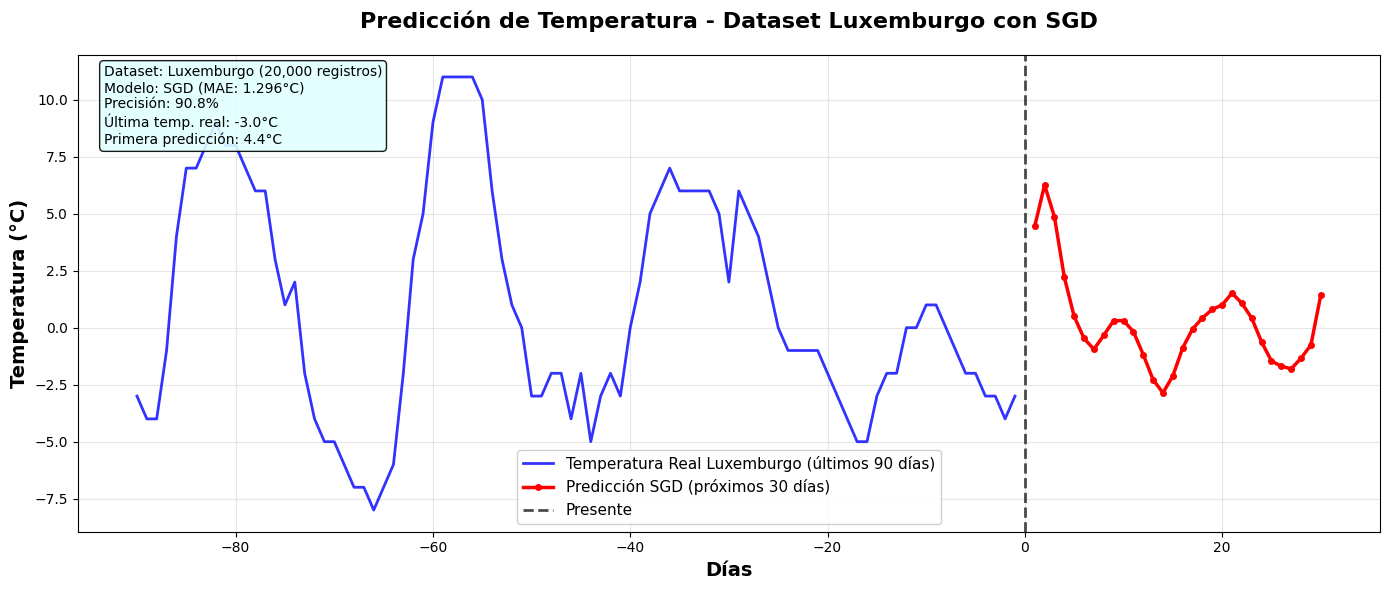


RESUMEN FINAL - SGD CON DATASET LUXEMBURGO
Error Absoluto Medio (MAE): 1.2964°C
Precisión del Modelo: 90.8%
Error Cuadrático Medio (MSE): 2.6684
Temperatura real actual: -3.00°C
Primera predicción: 4.44°C
Promedio predicciones: 0.22°C
Tendencia: Descendente


In [ ]:

plt.figure(figsize=(14, 6))

dias_contexto = 90
temp_historica = y[-dias_contexto:]
indices_historicos = np.arange(-dias_contexto, 0)
indices_prediccion = np.arange(1, PASOS_PREDICCION + 1)

plt.plot(indices_historicos, temp_historica, 'b-', 
         label=f'Temperatura Real Luxemburgo (últimos {dias_contexto} días)', 
         linewidth=2, alpha=0.8)
plt.plot(indices_prediccion, predicciones_30_dias, 'r-', 
         label=f'Predicción SGD (próximos {PASOS_PREDICCION} días)', 
         linewidth=2.5, marker='o', markersize=4)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.7, 
           label='Presente', linewidth=2)

plt.xlabel('Días', fontsize=14, fontweight='bold')
plt.ylabel('Temperatura (°C)', fontsize=14, fontweight='bold')
plt.title('Predicción de Temperatura - Dataset Luxemburgo con SGD', 
          fontsize=16, fontweight='bold', pad=20)
plt.legend(fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3)

info_box = (f'Dataset: Luxemburgo ({len(df):,} registros)\n'
            f'Modelo: SGD (MAE: {mejor_resultado["mae"]:.3f}°C)\n'
            f'Precisión: {mejor_resultado["precision"]:.1f}%\n'
            f'Última temp. real: {y[-1]:.1f}°C\n'
            f'Primera predicción: {predicciones_30_dias[0]:.1f}°C')

plt.text(0.02, 0.98, info_box, 
         transform=plt.gca().transAxes, 
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.9),
         fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nRESUMEN FINAL - SGD CON DATASET LUXEMBURGO")
print()
print(f"Error Absoluto Medio (MAE): {mejor_resultado['mae']:.4f}°C")
print(f"Precisión del Modelo: {mejor_resultado['precision']:.1f}%")
print(f"Error Cuadrático Medio (MSE): {mejor_resultado['mse']:.4f}")
print(f"Temperatura real actual: {y[-1]:.2f}°C")
print(f"Primera predicción: {predicciones_30_dias[0]:.2f}°C")
print(f"Promedio predicciones: {predicciones_30_dias.mean():.2f}°C")
print(f"Tendencia: {'Ascendente' if predicciones_30_dias[-1] > predicciones_30_dias[0] else 'Descendente'}")
print()

## ----------------------ADAM-----------------------

In [ ]:
# ENTRENAMIENTO CON ADAM - DATASET LUXEMBURGO

print("ENTRENAMIENTO CON OPTIMIZADOR ADAM")
print()

modelo_adam = construir_modelo(X_entrenamiento.shape[1])
optimizador_adam = torch.optim.Adam(modelo_adam.parameters(), lr=0.001)

historial_adam = entrenar_modelo(
    modelo_adam, 
    optimizador_adam, 
    dataloader, 
    epocas=100, 
    nombre="Adam"
)

resultado_adam = evaluar_modelo(modelo_adam, dataloader['validacion'], escalador_y, y_validacion)

print(f"\nRESULTADOS ADAM - DATASET LUXEMBURGO:")
print(f"   MAE: {resultado_adam['mae']:.4f}°C")
print(f"   Precisión: {resultado_adam['precision']:.1f}%")
print(f"   MSE: {resultado_adam['mse']:.4f}")
print(f"   Épocas entrenadas: {historial_adam['epocas_totales']}")

print(f"\nCOMPARACIÓN INICIAL SGD vs ADAM:")
print(f"   SGD  - MAE: {mejor_resultado['mae']:.4f}°C | Precisión: {mejor_resultado['precision']:.1f}%")
print(f"   Adam - MAE: {resultado_adam['mae']:.4f}°C | Precisión: {resultado_adam['precision']:.1f}%")

if resultado_adam['mae'] < mejor_resultado['mae']:
    print(f"   Adam es superior por {mejor_resultado['mae'] - resultado_adam['mae']:.4f}°C")
else:
    print(f"   SGD es superior por {resultado_adam['mae'] - mejor_resultado['mae']:.4f}°C")

print(f"\nModelo Adam entrenado exitosamente con dataset Luxemburgo")

ENTRENAMIENTO CON OPTIMIZADOR ADAM
Iniciando entrenamiento de Adam...
Adam - Early stopping en época 15

RESULTADOS ADAM - DATASET LUXEMBURGO:
   MAE: 0.9904°C
   Precisión: 93.0%
   MSE: 1.7458
   Épocas entrenadas: 15

COMPARACIÓN INICIAL SGD vs ADAM:
   SGD  - MAE: 1.2964°C | Precisión: 90.8%
   Adam - MAE: 0.9904°C | Precisión: 93.0%
   Adam es superior por 0.3059°C

Modelo Adam entrenado exitosamente con dataset Luxemburgo
Adam - Early stopping en época 15

RESULTADOS ADAM - DATASET LUXEMBURGO:
   MAE: 0.9904°C
   Precisión: 93.0%
   MSE: 1.7458
   Épocas entrenadas: 15

COMPARACIÓN INICIAL SGD vs ADAM:
   SGD  - MAE: 1.2964°C | Precisión: 90.8%
   Adam - MAE: 0.9904°C | Precisión: 93.0%
   Adam es superior por 0.3059°C

Modelo Adam entrenado exitosamente con dataset Luxemburgo


# VISUALIZACIÓN CURVAS DE ENTRENAMIENTO - ADAM LUXEMBURGO


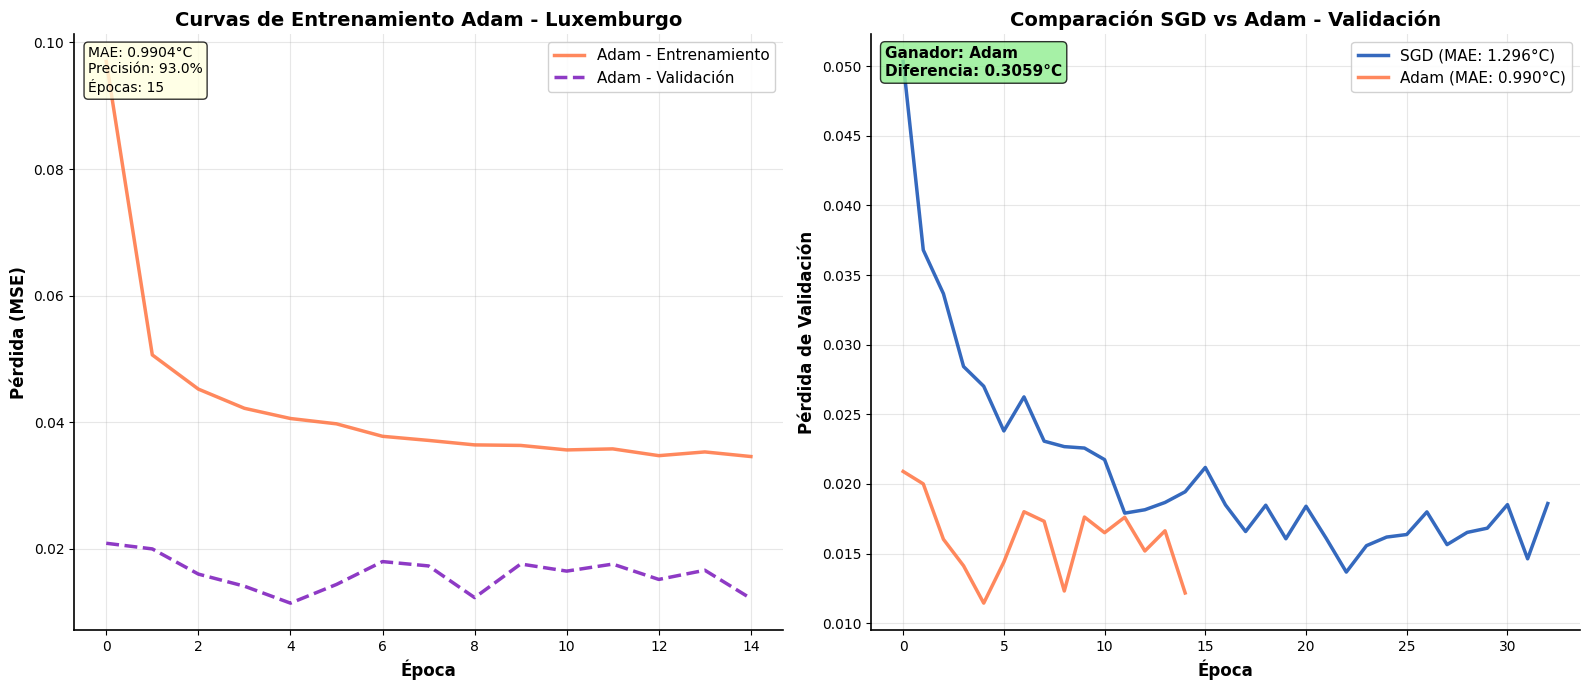

Gráficas comparativas generadas
Mejor pérdida Adam: 0.011436
Mejor pérdida SGD: 0.013666


In [ ]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

ax1.plot(historial_adam['perdida_entrenamiento'], 
         label='Adam - Entrenamiento', 
         color="#FF6B35", linewidth=2.5, alpha=0.8)
ax1.plot(historial_adam['perdida_validacion'], 
         label='Adam - Validación', 
         color="#7209B7", linestyle='--', linewidth=2.5, alpha=0.8)

ax1.set_title('Curvas de Entrenamiento Adam - Luxemburgo', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Época', fontsize=12, fontweight='bold')
ax1.set_ylabel('Pérdida (MSE)', fontsize=12, fontweight='bold')
ax1.legend(fontsize=11, framealpha=0.9)
ax1.grid(True, alpha=0.3, linewidth=0.8)

info_adam = (f'MAE: {resultado_adam["mae"]:.4f}°C\n'
             f'Precisión: {resultado_adam["precision"]:.1f}%\n'
             f'Épocas: {historial_adam["epocas_totales"]}')

ax1.text(0.02, 0.98, info_adam, 
         transform=ax1.transAxes, 
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8),
         fontsize=10)

ax2.plot(historial_sgd['perdida_validacion'], 
         label=f'SGD (MAE: {mejor_resultado["mae"]:.3f}°C)', 
         color="#0244AE", linewidth=2.5, alpha=0.8)
ax2.plot(historial_adam['perdida_validacion'], 
         label=f'Adam (MAE: {resultado_adam["mae"]:.3f}°C)', 
         color="#FF6B35", linewidth=2.5, alpha=0.8)

ax2.set_title('Comparación SGD vs Adam - Validación', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Época', fontsize=12, fontweight='bold')
ax2.set_ylabel('Pérdida de Validación', fontsize=12, fontweight='bold')
ax2.legend(fontsize=11, framealpha=0.9)
ax2.grid(True, alpha=0.3, linewidth=0.8)

ganador = "Adam" if resultado_adam['mae'] < mejor_resultado['mae'] else "SGD"
diferencia = abs(resultado_adam['mae'] - mejor_resultado['mae'])

ax2.text(0.02, 0.98, f'Ganador: {ganador}\nDiferencia: {diferencia:.4f}°C', 
         transform=ax2.transAxes, 
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8),
         fontsize=11, fontweight='bold')

for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_linewidth(1.2)

plt.tight_layout()
plt.show()

print(f"Gráficas comparativas generadas")
print(f"Mejor pérdida Adam: {min(historial_adam['perdida_validacion']):.6f}")
print(f"Mejor pérdida SGD: {min(historial_sgd['perdida_validacion']):.6f}")

# PREDICCIÓN 30 DÍAS CON ADAM - LUXEMBURGO

In [37]:


print("PREDICCIÓN CON MODELO ADAM - DATASET LUXEMBURGO")
print()

modelo_adam.eval()
predicciones_adam_30_dias = []
ventana_adam = ventana_inicial.copy()

print(f"Ejecutando predicción iterativa con Adam...")
print()

for dia in range(PASOS_PREDICCION):
    lags = ventana_adam[-ventana:]
    caract_temporales = caracteristicas_futuras[dia]
    caract_adicionales = variables_futuras[dia]
    
    x_input = np.hstack([lags, caract_temporales, caract_adicionales])
    
    x_input_norm = escalador_X.transform(x_input.reshape(1, -1))[0]
    x_tensor = torch.tensor(x_input_norm, dtype=torch.float32).unsqueeze(0)
    
    with torch.no_grad():
        y_pred_norm = modelo_adam(x_tensor).numpy().reshape(-1)[0]
    
    y_pred = escalador_y.inverse_transform([[y_pred_norm]])[0][0]
    
    predicciones_adam_30_dias.append(y_pred)
    ventana_adam = np.append(ventana_adam, y_pred)
    
    fecha_pred = fechas_futuras[dia].strftime('%Y-%m-%d')
    print(f"{fecha_pred} | Día {dia+1:2d}: {y_pred:6.2f}°C")

predicciones_adam_30_dias = np.array(predicciones_adam_30_dias)

print(f"\nPredicción Adam completada")
print(f"Rango predicciones Adam: {predicciones_adam_30_dias.min():.2f}°C a {predicciones_adam_30_dias.max():.2f}°C")
print(f"Temperatura promedio Adam: {predicciones_adam_30_dias.mean():.2f}°C")

diferencia_promedio = np.abs(predicciones_30_dias - predicciones_adam_30_dias).mean()
print(f"\nCOMPARACIÓN DE PREDICCIONES:")
print(f"   Diferencia promedio SGD vs Adam: {diferencia_promedio:.3f}°C")
print(f"   Correlación entre predicciones: {np.corrcoef(predicciones_30_dias, predicciones_adam_30_dias)[0,1]:.3f}")

tendencia_sgd = "Ascendente" if predicciones_30_dias[-1] > predicciones_30_dias[0] else "Descendente"
tendencia_adam = "Ascendente" if predicciones_adam_30_dias[-1] > predicciones_adam_30_dias[0] else "Descendente"

print(f"   Tendencia SGD: {tendencia_sgd}")
print(f"   Tendencia Adam: {tendencia_adam}")

if tendencia_sgd == tendencia_adam:
    print(f"   Ambos modelos coinciden en la tendencia")
else:
    print(f"   Los modelos difieren en la tendencia")

PREDICCIÓN CON MODELO ADAM - DATASET LUXEMBURGO

Ejecutando predicción iterativa con Adam...

2064-10-04 | Día  1:   3.37°C
2064-10-05 | Día  2:   5.95°C
2064-10-06 | Día  3:   4.67°C
2064-10-07 | Día  4:   3.28°C
2064-10-08 | Día  5:   1.47°C
2064-10-09 | Día  6:  -0.31°C
2064-10-10 | Día  7:  -1.22°C
2064-10-11 | Día  8:  -0.67°C
2064-10-12 | Día  9:   0.34°C
2064-10-13 | Día 10:   0.77°C
2064-10-14 | Día 11:  -0.13°C
2064-10-15 | Día 12:  -0.97°C
2064-10-16 | Día 13:  -2.06°C
2064-10-17 | Día 14:  -3.03°C
2064-10-18 | Día 15:  -2.72°C
2064-10-19 | Día 16:  -0.99°C
2064-10-20 | Día 17:  -0.31°C
2064-10-21 | Día 18:  -0.41°C
2064-10-22 | Día 19:   0.46°C
2064-10-23 | Día 20:   0.70°C
2064-10-24 | Día 21:   1.75°C
2064-10-25 | Día 22:   1.62°C
2064-10-26 | Día 23:   0.85°C
2064-10-27 | Día 24:   0.04°C
2064-10-28 | Día 25:  -0.99°C
2064-10-29 | Día 26:  -1.68°C
2064-10-30 | Día 27:  -2.38°C
2064-10-31 | Día 28:  -2.28°C
2064-11-01 | Día 29:  -2.44°C
2064-11-02 | Día 30:  -0.18°C

Predi

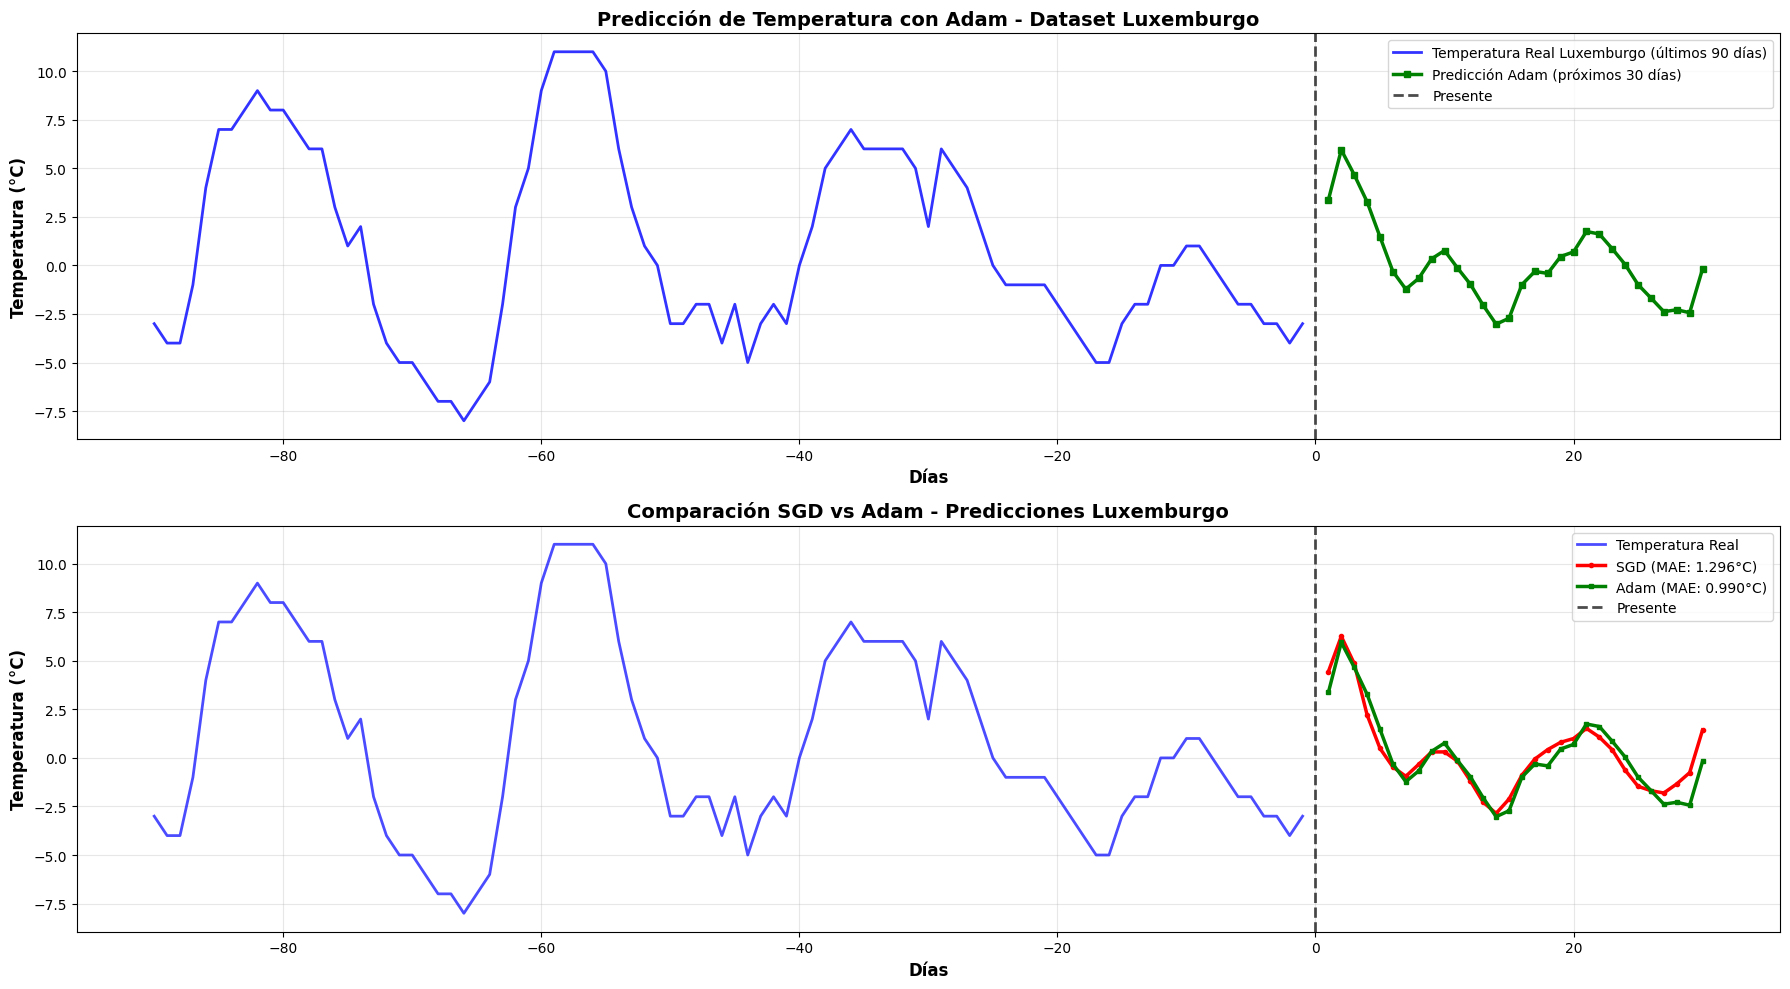


ANÁLISIS FINAL COMPLETO - DATASET LUXEMBURGO
MÉTRICAS DE RENDIMIENTO:
   SGD  - MAE: 1.2964°C | Precisión: 90.8% | Épocas: 33
   Adam - MAE: 0.9904°C | Precisión: 93.0% | Épocas: 15
   Mejor modelo: Adam (MAE: 0.9904°C)

PREDICCIONES (30 DÍAS):
   Temperatura actual: -3.00°C
   Primera predicción SGD: 4.44°C
   Primera predicción Adam: 3.37°C
   Promedio SGD: 0.22°C
   Promedio Adam: 0.08°C

ANÁLISIS DATASET LUXEMBURGO:
   Registros totales: 20,000
   Rango temperatura: -18.0°C a 42.0°C
   Período: 2010-01-01 a 2064-10-03
   Variables en español: Sí
   Modelo optimizado para predicción temporal: Sí
Análisis completo con dataset Luxemburgo finalizado exitosamente


In [36]:
# VISUALIZACIÓN FINAL COMPARATIVA - LUXEMBURGO

plt.figure(figsize=(18, 10))

# GRÁFICA 1: PREDICCIONES ADAM
plt.subplot(2, 1, 1)
plt.plot(indices_historicos, temp_historica, 'b-', 
         label=f'Temperatura Real Luxemburgo (últimos {dias_contexto} días)', 
         linewidth=2, alpha=0.8)
plt.plot(indices_prediccion, predicciones_adam_30_dias, 'g-', 
         label=f'Predicción Adam (próximos {PASOS_PREDICCION} días)', 
         linewidth=2.5, marker='s', markersize=4)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.7, 
           label='Presente', linewidth=2)

plt.xlabel('Días', fontsize=12, fontweight='bold')
plt.ylabel('Temperatura (°C)', fontsize=12, fontweight='bold')
plt.title('Predicción de Temperatura con Adam - Dataset Luxemburgo', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# GRÁFICA 2: COMPARACIÓN DIRECTA SGD vs ADAM
plt.subplot(2, 1, 2)
plt.plot(indices_historicos, temp_historica, 'b-', 
         label='Temperatura Real', linewidth=2, alpha=0.7)
plt.plot(indices_prediccion, predicciones_30_dias, 'r-', 
         label=f'SGD (MAE: {mejor_resultado["mae"]:.3f}°C)', 
         linewidth=2.5, marker='o', markersize=3)
plt.plot(indices_prediccion, predicciones_adam_30_dias, 'g-', 
         label=f'Adam (MAE: {resultado_adam["mae"]:.3f}°C)', 
         linewidth=2.5, marker='s', markersize=3)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.7, 
           label='Presente', linewidth=2)

plt.xlabel('Días', fontsize=12, fontweight='bold')
plt.ylabel('Temperatura (°C)', fontsize=12, fontweight='bold')
plt.title('Comparación SGD vs Adam - Predicciones Luxemburgo', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

mejor_modelo_final = "SGD" if mejor_resultado['mae'] < resultado_adam['mae'] else "Adam"
mejor_mae = min(mejor_resultado['mae'], resultado_adam['mae'])

print(f"\nANÁLISIS FINAL COMPLETO - DATASET LUXEMBURGO")


print(f"MÉTRICAS DE RENDIMIENTO:")
print(f"   SGD  - MAE: {mejor_resultado['mae']:.4f}°C | Precisión: {mejor_resultado['precision']:.1f}% | Épocas: {historial_sgd['epocas_totales']}")
print(f"   Adam - MAE: {resultado_adam['mae']:.4f}°C | Precisión: {resultado_adam['precision']:.1f}% | Épocas: {historial_adam['epocas_totales']}")
print(f"   Mejor modelo: {mejor_modelo_final} (MAE: {mejor_mae:.4f}°C)")

print(f"\nPREDICCIONES (30 DÍAS):")
print(f"   Temperatura actual: {y[-1]:.2f}°C")
print(f"   Primera predicción SGD: {predicciones_30_dias[0]:.2f}°C")
print(f"   Primera predicción Adam: {predicciones_adam_30_dias[0]:.2f}°C")
print(f"   Promedio SGD: {predicciones_30_dias.mean():.2f}°C")
print(f"   Promedio Adam: {predicciones_adam_30_dias.mean():.2f}°C")

print(f"\nANÁLISIS DATASET LUXEMBURGO:")
print(f"   Registros totales: {len(df):,}")
print(f"   Rango temperatura: {y.min():.1f}°C a {y.max():.1f}°C")
print(f"   Período: {df['fecha'].min()} a {df['fecha'].max()}")
print(f"   Variables en español: Sí")
print(f"   Modelo optimizado para predicción temporal: Sí")

print(f"Análisis completo con dataset Luxemburgo finalizado exitosamente")